# The Black-Scholes Model

The **Black-Scholes model** is a mathematical framework for pricing European call and put options. It assumes that the price of the underlying asset follows a geometric Brownian motion with constant drift and volatility.

**Black-Scholes Formula for a European Call Option:**

$$
C = S_0 N(d_1) - K e^{-rT} N(d_2)
$$

where:
- $C$ = Call option price
- $S_0$ = Current price of the underlying asset
- $K$ = Strike price
- $T$ = Time to maturity (in years)
- $r$ = Risk-free interest rate (annualized, continuously compounded)
- $\sigma$ = Volatility of the underlying asset (annualized standard deviation)
- $N(\cdot)$ = Cumulative distribution function of the standard normal distribution

and

$$
d_1 = \frac{\ln(S_0/K) + (r + 0.5\sigma^2)T}{\sigma\sqrt{T}}
$$
$$
d_2 = d_1 - \sigma\sqrt{T}
$$

**Parameters:**
- $S_0$: Current price of the underlying asset
- $K$: Strike price of the option
- $T$: Time to expiration (in years)
- $r$: Risk-free interest rate
- $\sigma$: Volatility of the underlying asset

**Core Assumptions:**
- The underlying asset price follows a log-normal distribution (geometric Brownian motion).
- Volatility ($\sigma$) and risk-free rate ($r$) are constant over the life of the option.
- No dividends are paid during the option's life.
- Markets are frictionless (no transaction costs or taxes).
- The option is European (can only be exercised at expiration).
- No arbitrage opportunities exist.

**Limitations:**
- Real markets often have changing volatility, jumps, or fat tails in returns.
- The model does not account for early exercise (American options) or discrete dividends.
- Assumes continuous trading and perfect liquidity.

---

The formulas and code in this notebook use the following variable names:
- `S0` for the current price of the underlying asset
- `K` for the strike price
- `T` for time to maturity
- `r` for the risk-free rate
- `sigma` for volatility

In [13]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider, Output
from IPython.display import display, Markdown

## Monte Carlo Simulation of Price Paths

Simulate up to 1000 price paths for the underlying asset using geometric Brownian motion (GBM).

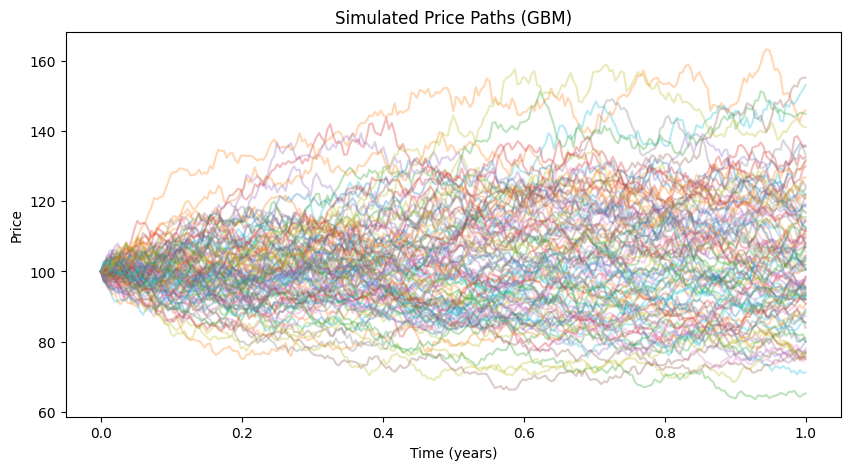

In [5]:
def simulate_gbm_paths(S0=100, mu=0.05, sigma=0.2, T=1, steps=252, n_paths=100):
    dt = T / steps
    t = np.linspace(0, T, steps+1)
    paths = np.zeros((n_paths, steps+1))
    paths[:, 0] = S0
    for i in range(n_paths):
        rand = np.random.normal(0, 1, steps)
        increments = (mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * rand
        paths[i, 1:] = S0 * np.exp(np.cumsum(increments))
    return t, paths

t, paths = simulate_gbm_paths(n_paths=100)
plt.figure(figsize=(10,5))
plt.plot(t, paths.T, alpha=0.3)
plt.title('Simulated Price Paths (GBM)')
plt.xlabel('Time (years)')
plt.ylabel('Price')
plt.show()

# Black-Scholes Model: Theory and Simulation

This notebook covers the Black-Scholes model for European options, including interactive calculators and Monte Carlo simulation of price paths under geometric Brownian motion.

In [14]:
def black_scholes_price(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        price = S * stats.norm.cdf(d1) - K * np.exp(-r * T) * stats.norm.cdf(d2)
    else:
        price = K * np.exp(-r * T) * stats.norm.cdf(-d2) - S * stats.norm.cdf(-d1)
    return price

def black_scholes_greeks(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    delta = stats.norm.cdf(d1) if option_type == 'call' else -stats.norm.cdf(-d1)
    vega = S * stats.norm.pdf(d1) * np.sqrt(T)
    theta = (-S * stats.norm.pdf(d1) * sigma / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * stats.norm.cdf(d2 if option_type == 'call' else -d2))
    return {'delta': delta, 'vega': vega, 'theta': theta}

## Black-Scholes Calculator

Interactively explore the Black-Scholes price and greeks for European options.

In [4]:
def interactive_black_scholes():
    S_slider = FloatSlider(value=100, min=10, max=200, step=1, description='Spot (S)')
    K_slider = FloatSlider(value=100, min=10, max=200, step=1, description='Strike (K)')
    T_slider = FloatSlider(value=1, min=0.01, max=2, step=0.01, description='Time (T, yrs)')
    r_slider = FloatSlider(value=0.01, min=0, max=0.1, step=0.001, description='Rate (r)')
    sigma_slider = FloatSlider(value=0.2, min=0.01, max=1, step=0.01, description='Volatility (σ)')
    option_type = ['call', 'put']
    out = Output()

    def update(S, K, T, r, sigma, option_type):
        with out:
            out.clear_output()
            price = black_scholes_price(S, K, T, r, sigma, option_type)
            greeks = black_scholes_greeks(S, K, T, r, sigma, option_type)
            display(Markdown(f"**Option Price:** {price:.2f}"))
            display(Markdown(f"**Delta:** {greeks['delta']:.4f}  |  **Vega:** {greeks['vega']:.4f}  |  **Theta:** {greeks['theta']:.4f}"))
    
    interact(update, S=S_slider, K=K_slider, T=T_slider, r=r_slider, sigma=sigma_slider, option_type=option_type)
    display(out)

interactive_black_scholes()

interactive(children=(FloatSlider(value=100.0, description='Spot (S)', max=200.0, min=10.0, step=1.0), FloatSl…

Output()

## Black-Scholes Option Price Over a Simulated Path

For a single simulated price path, calculate the Black-Scholes price of a call option at each time step, using the simulated price as $S$ and the time remaining as $T-t$.

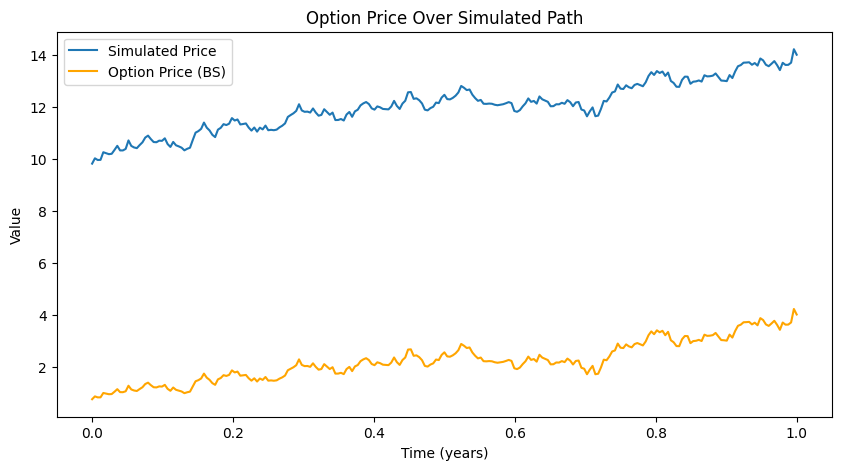

In [39]:
# Parameters
S0, K, r, sigma, T, steps = 9.81, 10, 0.01, 0.2, 1, 252
mu = 0.05
n_paths = 1

t, paths = simulate_gbm_paths(S0, mu, sigma, T, steps, n_paths)
S_path = paths[0]
option_prices = []
for i, S in enumerate(S_path):
    t_remain = T - t[i]
    if t_remain <= 0:
        option_prices.append(max(S - K, 0))
    else:
        option_prices.append(black_scholes_price(S, K, t_remain, r, sigma, option_type='call'))
plt.figure(figsize=(10,5))
plt.plot(t, S_path, label='Simulated Price')
plt.plot(t, option_prices, label='Option Price (BS)', color='orange')
plt.title('Option Price Over Simulated Path')
plt.xlabel('Time (years)')
plt.ylabel('Value')
plt.legend()
plt.show()

## Monte Carlo Option Pricing Under Black-Scholes Assumptions

While the Black-Scholes formula provides a closed-form solution for European options, we can also estimate the option price numerically using Monte Carlo simulation. This approach is especially useful for more complex payoffs, but it also serves as a useful check for the analytic result.

**Steps:**
1. Simulate many possible future price paths for the underlying asset using geometric Brownian motion (log-normal returns).
2. For each path, calculate the option payoff at expiry (e.g., $\max(S_T - K, 0)$ for a call).
3. Average the payoffs across all paths.
4. Discount the average payoff to present value using the risk-free rate.

This method converges to the Black-Scholes price as the number of simulations increases.

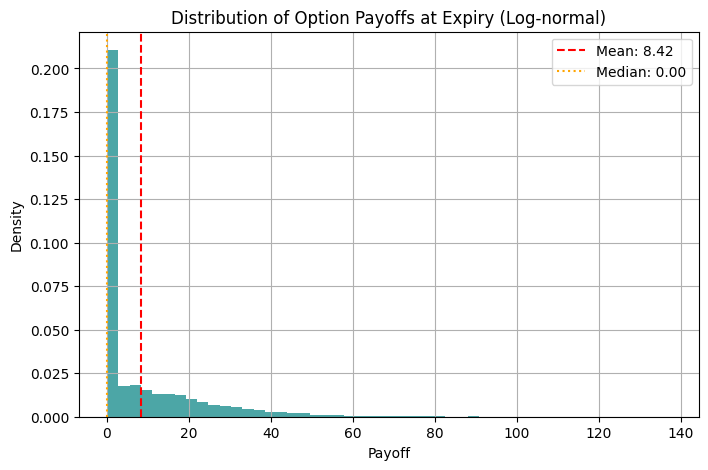

Monte Carlo option price (log-normal): 8.34


In [40]:
def monte_carlo_option_price_bs(S0=100, K=100, r=0.01, sigma=0.2, T=1, steps=252, n_paths=10000, option_type='call', plot_expiry_payoff=False):
    dt = T / steps
    S_T = np.zeros(n_paths)
    for i in range(n_paths):
        # Simulate log-normal returns
        increments = (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * np.random.normal(0, 1, steps)
        S_path = S0 * np.exp(np.cumsum(increments))
        S_T[i] = S_path[-1]
    if option_type == 'call':
        payoffs = np.maximum(S_T - K, 0)
    else:
        payoffs = np.maximum(K - S_T, 0)
    price = np.exp(-r * T) * np.mean(payoffs)
    if plot_expiry_payoff:
        plt.figure(figsize=(8,5))
        plt.hist(payoffs, bins=50, density=True, alpha=0.7, color='teal')
        mean_payoff = np.mean(payoffs)
        median_payoff = np.median(payoffs)
        plt.axvline(mean_payoff, color='red', linestyle='--', label=f'Mean: {mean_payoff:.2f}')
        plt.axvline(median_payoff, color='orange', linestyle=':', label=f'Median: {median_payoff:.2f}')
        plt.title('Distribution of Option Payoffs at Expiry (Log-normal)')
        plt.xlabel('Payoff')
        plt.ylabel('Density')
        plt.legend()
        plt.grid(True)
        plt.show()
    return price

# Example usage:
price_mc = monte_carlo_option_price_bs(plot_expiry_payoff=True)
print(f"Monte Carlo option price (log-normal): {price_mc:.2f}")